<a href="https://colab.research.google.com/github/shekharkoirala/60daysofUdacity/blob/master/notebooks/day6/pyAv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!sudo apt-get install -y python-dev pkg-config
!sudo apt-get install -y \
    libavformat-dev libavcodec-dev libavdevice-dev \
    libavutil-dev libswscale-dev libswresample-dev libavfilter-dev
!pip3 install av

In [0]:
!mkdir images

### Saving Key Frames

In [0]:
import av
container = av.open("video.mp4")

#setting the Thread Type
container.streams.video[0].thread_type = 'AUTO'

#saving the key franes
for frame in container.decode(video=0):
    frame.to_image().save('./images/frame-%04d.jpg' % frame.index, quality = 80)
print(" all images are saved ")

### Extracting Only Video

In [0]:

#remuxing the only video
container = av.open("video.mp4")
output = av.open('remuxed.mkv', 'w')

# Make an output stream using the input as a template. This copies the stream
# setup from one to the other.
in_stream = container.streams.video[0]
out_stream = output.add_stream(template=in_stream)

for packet in container.demux(in_stream):

    print(packet)

    # We need to skip the "flushing" packets that `demux` generates.
    if packet.dts is None:
        continue

    # We need to assign the packet to the new stream.
    packet.stream = out_stream

    output.mux(packet)

output.close()

### Extracting Only Audio

In [0]:

#remuxing the only video
container = av.open("video.mp4")
output = av.open('audio.mkv', 'w')

# Make an output stream using the input as a template. This copies the stream
# setup from one to the other.
in_stream = container.streams.audio[0]
out_stream = output.add_stream(template=in_stream)

for packet in container.demux(in_stream):

    print(packet)

    # We need to skip the "flushing" packets that `demux` generates.
    if packet.dts is None:
        continue

    # We need to assign the packet to the new stream.
    packet.stream = out_stream

    output.mux(packet)

output.close()

# Visuallizing the Key Frames

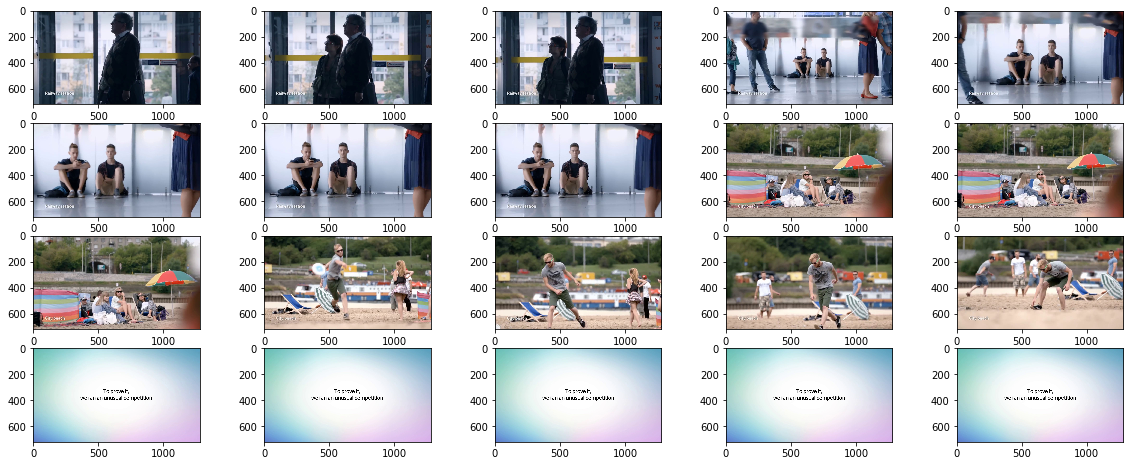

In [6]:
import PIL
from glob import glob
import matplotlib.pyplot as plt

images = [ PIL.Image.open("./images/frame-0"+ str(i) + "0.jpg") for i in range(10,30)]

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

# **Movie** **Barcode**

In [0]:
import numpy as np
from PIL import Image
container = av.open("video.mp4")
container.streams.video[0].thread_type = 'AUTO'  # Go faster!

columns = []
for frame in container.decode(video=0):

#     print(frame)
    array = frame.to_ndarray(format='rgb24')

    # Collapse down to a column.
    column = array.mean(axis=1)

    # Convert to bytes, as the `mean` turned our array into floats.
    column = column.clip(0, 255).astype('uint8')

    # Get us in the right shape for the `hstack` below.
    column = column.reshape(-1, 1, 3)

    columns.append(column)

full_array = np.hstack(columns)
full_img = Image.fromarray(full_array, 'RGB')
full_img = full_img.resize((800, 200))
full_img.save('./barcode.jpg', quality=85)

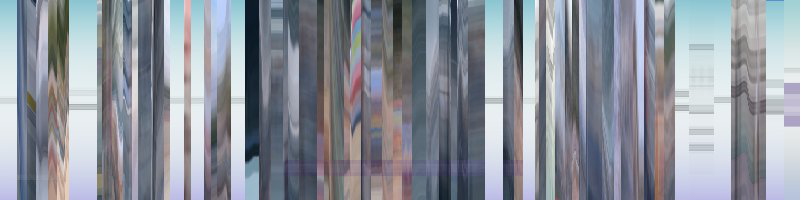

In [12]:
PIL.Image.open("./barcode.jpg")

#  Generate Random Video

In [16]:
from __future__ import division

import numpy as np

import av


duration = 4
fps = 24
total_frames = duration * fps

container = av.open('test.mp4', mode='w')

stream = container.add_stream('mpeg4', rate=fps)
stream.width = 480
stream.height = 320
stream.pix_fmt = 'yuv420p'

for frame_i in range(total_frames):

    img = np.empty((480, 320, 3))
    img[:, :, 0] = 0.5 + 0.5 * np.sin(2 * np.pi * (0 / 3 + frame_i / total_frames))
    img[:, :, 1] = 0.5 + 0.5 * np.sin(2 * np.pi * (1 / 3 + frame_i / total_frames))
    img[:, :, 2] = 0.5 + 0.5 * np.sin(2 * np.pi * (2 / 3 + frame_i / total_frames))

    img = np.round(255 * img).astype(np.uint8)
    img = np.clip(img, 0, 255)

    frame = av.VideoFrame.from_ndarray(img, format='rgb24')
    for packet in stream.encode(frame):
        container.mux(packet)

# Flush stream
for packet in stream.encode():
    container.mux(packet)

# Close the file
container.close()

Using AVStream.codec to pass codec parameters to muxers is deprecated, use AVStream.codecpar instead.


## Play Video

In [0]:
import av
import cv2

camera_path = "rtsp://path_to_rts_stream"
container = av.open(camera_path, "r")
video_stream = container.streams.video[0]

for packet in container.demux(video_stream):
    for frame in packet.decode():
        image = frame.to_nd_array(format="bgr24")
        cv2.imshow("Test", image)
        if cv2.waitKey(20) & 0xFF == 27:
            break

cv2.destroyAllWindows()

## Record Video

In [0]:
import av

#If you are recording video in the same codec as the one received from rtsp stream
#you can just copy packets (no need to decode them) to the output container
#This way reduces load on processor because there is no need for decoding/encoding frames

camera_path = "rtsp://path_to_rts_stream"
container = av.open(camera_path, "r")
video_stream = container.streams.video[0]

out_container = av.open("test.mp4", "w", format='mp4')
outstream = out_container.add_stream(template=video_stream)
outstream.options = {}

first_packet = True
for packet in container.demux(video_stream):
    if first_packet:
        #There is a bug in pyav where first frame has the decoding/presentation timestamps set to some high value.
        #This is causing pyav recording to crash so we manualy set the first frame dts and pts to 0
        packet.dts = 0
        packet.pts = 0
        first_packet = False

    out_container.mux(packet)

# Video Augmentation

In [18]:
!sudo pip3 install git+https://github.com/okankop/vidaug

  Cloning https://github.com/okankop/vidaug to /tmp/pip-req-build-fy343sxp
  Running command git clone -q https://github.com/okankop/vidaug /tmp/pip-req-build-fy343sxp
  Stored in directory: /tmp/pip-ephem-wheel-cache-s2z0z9qu/wheels/3f/87/a3/14ed7eb5a878e2e239961990c700a400836e369fc109ecad86
Successfully built vidaug


In [0]:
from vidaug import augmentors as va
images = [ PIL.Image.open("./images/frame-0"+ str(i) + "0.jpg") for i in range(10,90)]
sometimes = lambda aug: va.Sometimes(0.5, aug) # Used to apply augmentor with 50% probability
seq = va.Sequential([
    va.RandomCrop(size=(512, 1024)),# randomly crop video with a size of (240 x 180)
    va.Pepper(),
    va.PiecewiseAffineTransform(displacement=5, displacement_kernel=23, displacement_magnification=7),
    va.RandomRotate(degrees=10), # randomly rotates the video with a degree randomly choosen from [-10, 10]  
    sometimes(va.HorizontalFlip()) # horizontally flip the video with 50% probability
])


# 'video' should be either a list of images from type of numpy array or PIL images
video_aug = seq(images)

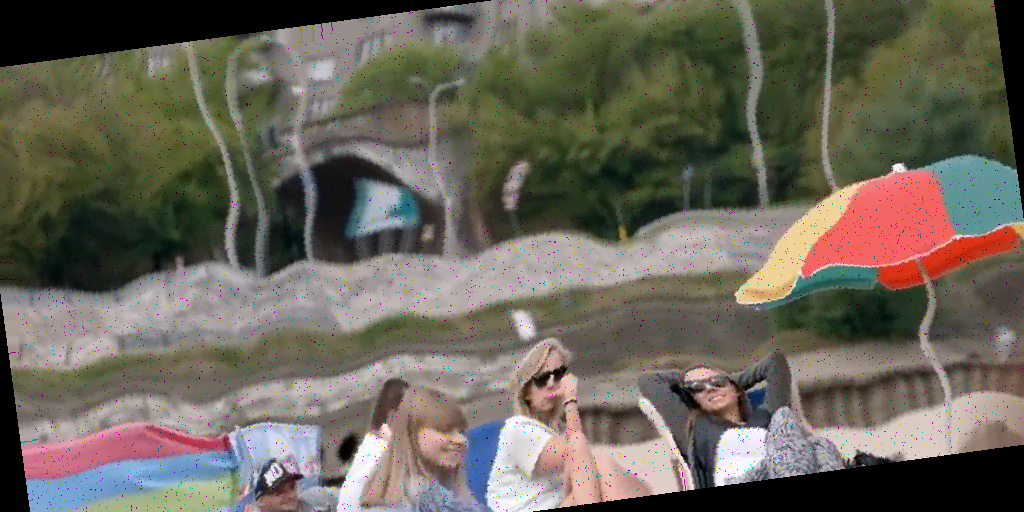

In [47]:
video_aug[10]